Carregar bibliotecas para manipulação de dados

In [1]:
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier


Carregar dataset com dados sobre pingüins

In [2]:
df = sns.load_dataset('penguins')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None


In [3]:
print(df)

    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2     

Algumas células vazias (NaN) devem ser tratadas

In [4]:
print(df.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


Podemos assumir valores dentro da distribuição conhecida, ou remover os elementos com informações faltantes

In [5]:
# Remove campos não preenchidos de colunas listadas
df = df.dropna(subset=['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm', 'body_mass_g', 'sex'])
print(df)

    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2     

Agora tentaremos classificar os pingüins em termos de suas espécies baseado nos seus dados

In [6]:

y = df['species']
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=100)
clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10,
                        random_state=0).fit(x_train, y_train)
y_predicted = clf.predict(x_test)

print(y_test)
print(y_predicted[:])

ValueError: could not convert string to float: 'Torgersen'

Os nomes das ilhas e sexo do animal são strings, que não são aceitas por classificadores.
Devem ser transformados em valores numéricos, em diferentes colunas prenchidas de forma binária, ou removidos

In [7]:
one_hot = OneHotEncoder()
encoded = one_hot.fit_transform(df[['island']])
df[one_hot.categories_[0]] = encoded.toarray()
df = df.drop(columns=['island'])

In [8]:
df.loc[df['sex'] =='Female', 'sex'] = 1.0
df.loc[df['sex'] =='Male', 'sex'] = 0.0
df['female'] = df['sex']
df = df.drop(columns=['sex'])

print(df.head())

  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie            39.1           18.7              181.0       3750.0   
1  Adelie            39.5           17.4              186.0       3800.0   
2  Adelie            40.3           18.0              195.0       3250.0   
4  Adelie            36.7           19.3              193.0       3450.0   
5  Adelie            39.3           20.6              190.0       3650.0   

   Biscoe  Dream  Torgersen female  
0     0.0    0.0        1.0    0.0  
1     0.0    0.0        1.0    1.0  
2     0.0    0.0        1.0    1.0  
4     0.0    0.0        1.0    1.0  
5     0.0    0.0        1.0    0.0  


In [9]:
y = df['species']

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], y,
                                                    test_size=0.3,
                                                    random_state=100)
clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=50,
                        random_state=0).fit(x_train, y_train)
y_predicted = clf.predict(x_test)


print("Acurácia:",metrics.accuracy_score(y_test, y_predicted))


Acurácia: 0.73


Acurácia: 1.0


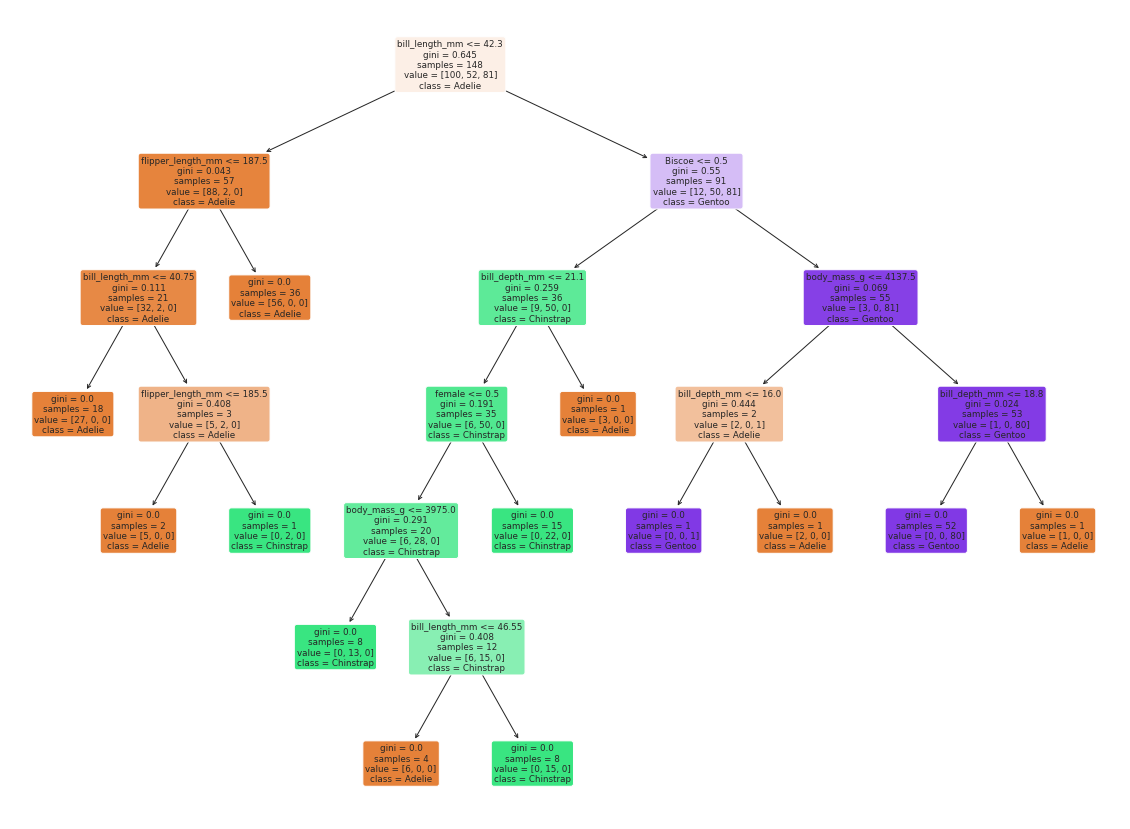

In [10]:
forest = RandomForestClassifier(n_estimators=100, random_state=100)
forest.fit(x_train,y_train)
y_predicted = forest.predict(x_test)
print("Acurácia:",metrics.accuracy_score(y_test, y_predicted))

fig = plt.figure(figsize=(20, 15))
plot_tree(forest.estimators_[0],
          feature_names=x_train.columns,
          class_names=df['species'].unique(),
          filled=True, rounded=True)

plt.show()

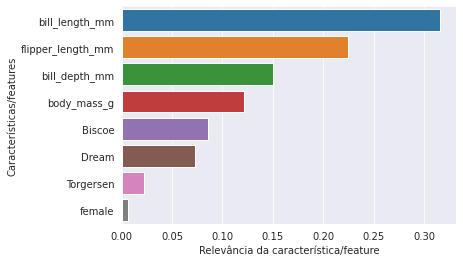

In [11]:
feature_imp = pd.Series(forest.feature_importances_,index=x_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Relevância da característica/feature')
plt.ylabel('Características/features')
plt.show()

Agora o método supervisionado K-Nearest Neighbors

In [22]:
for neighbors in [1,3,5,10]:
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(x_train, y_train)
    y_predicted = neigh.predict(x_test)
    print(y_predicted)
    print(y_test)
    print("Acurácia com %d vizinhos:" % neighbors,metrics.accuracy_score(y_test, y_predicted))

['Chinstrap' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo' 'Chinstrap' 'Chinstrap'
 'Gentoo' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo'
 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Gentoo' 'Adelie' 'Chinstrap' 'Gentoo' 'Adelie' 'Gentoo'
 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Adelie'
 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo' 'Chinstrap' 'Chinstrap' 'Gentoo'
 'Adelie' 'Adelie' 'Gentoo' 'Gentoo' 'Chinstrap' 'Gentoo' 'Gentoo'
 'Chinstrap' 'Adelie' 'Gentoo' 'Chinstrap' 'Adelie' 'Chinstrap' 'Adelie'
 'Gentoo' 'Adelie' 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo' 'Adelie'
 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Gentoo'
 'Chinstrap' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Chinstrap'
 'Chinstrap' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo']
184    Chinstrap
181    Chinstr